# Run tutorial for emd

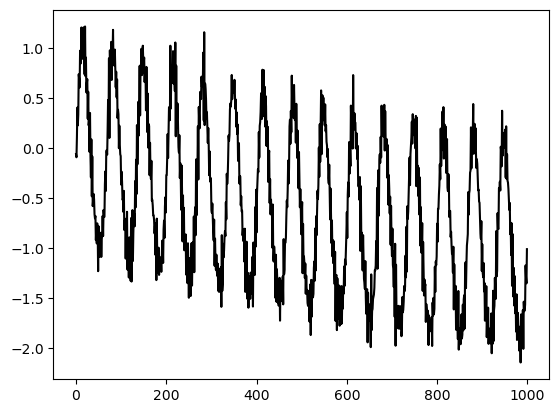

In [1]:
import emd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


sample_rate = 1000
seconds = 1
num_samples = sample_rate*seconds
time_vect = np.linspace(0, seconds, num_samples)
freq = 15

# Change extent of deformation from sinusoidal shape [-1 to 1]
nonlinearity_deg = .25

# Change left-right skew of deformation [-pi to pi]
nonlinearity_phi = -np.pi/4

# Create a non-linear oscillation
x = emd.simulate.abreu2010(freq, nonlinearity_deg, nonlinearity_phi, sample_rate, seconds)

x -= np.sin(2 * np.pi * 0.22 * time_vect)   # Add part of a very slow cycle as a trend

# Add a little noise - with low frequencies removed to make this example a
# little cleaner...
np.random.seed(42)
n = np.random.randn(1000,) * .2
nf = signal.savgol_filter(n, 3, 1)
n = n - nf

x = x + n

plt.figure()
plt.plot(x, 'k')

# sphinx_gallery_thumbnail_number = 8

(0.0, 150.0)

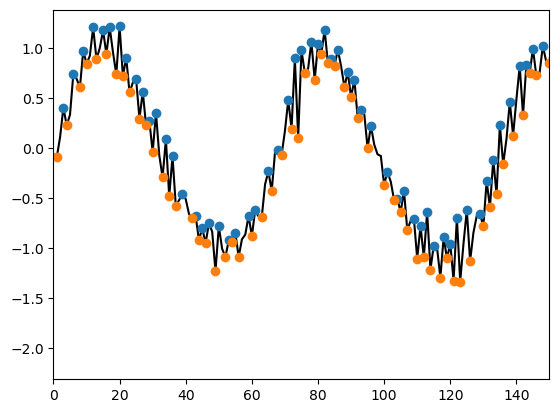

In [2]:
peak_locs, peak_mags = emd.sift.get_padded_extrema(x, pad_width=0, mode='peaks')
trough_locs, trough_mags = emd.sift.get_padded_extrema(x, pad_width=0, mode='troughs')

plt.figure()
plt.plot(x, 'k')
plt.plot(peak_locs, peak_mags, 'o')
plt.plot(trough_locs, trough_mags, 'o')
plt.xlim(0, 150)

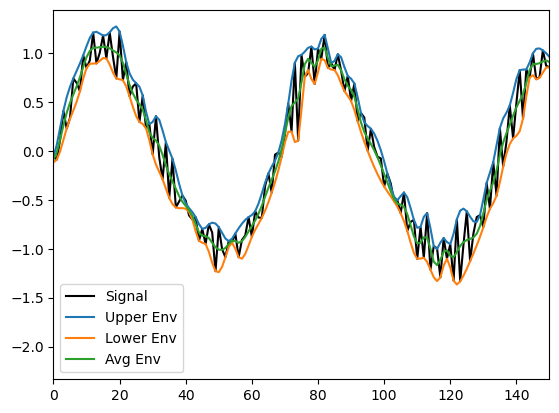

In [3]:
proto_imf = x.copy()
# Compute upper and lower envelopes
upper_env = emd.sift.interp_envelope(proto_imf, mode='upper')
lower_env = emd.sift.interp_envelope(proto_imf, mode='lower')

# Compute average envelope
avg_env = (upper_env+lower_env) / 2

plt.figure()
plt.plot(x, 'k')
plt.plot(upper_env)
plt.plot(lower_env)
plt.plot(avg_env)
plt.xlim(0, 150)
plt.legend(['Signal', 'Upper Env', 'Lower Env', 'Avg Env'])

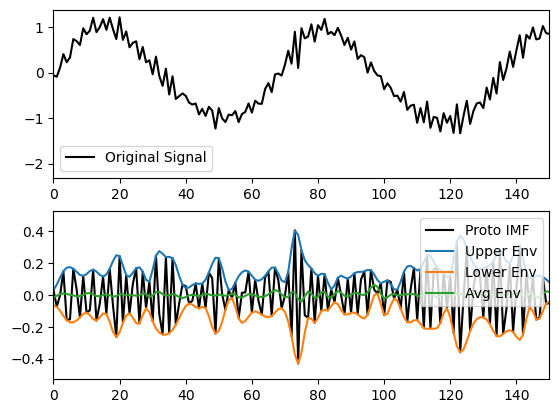

In [4]:
# Subtract slow dynamics from previous cell
proto_imf = x - avg_env

# Compute upper and lower envelopes
upper_env = emd.sift.interp_envelope(proto_imf, mode='upper')
lower_env = emd.sift.interp_envelope(proto_imf, mode='lower')

# Compute average envelope
avg_env = (upper_env+lower_env) / 2

plt.figure()
plt.subplot(211)
plt.plot(x, 'k')
plt.xlim(0, 150)
plt.legend(['Original Signal'])

plt.subplot(212)
plt.plot(proto_imf, 'k')
plt.plot(upper_env)
plt.plot(lower_env)
plt.plot(avg_env)
plt.xlim(0, 150)
plt.legend(['Proto IMF', 'Upper Env', 'Lower Env', 'Avg Env'])

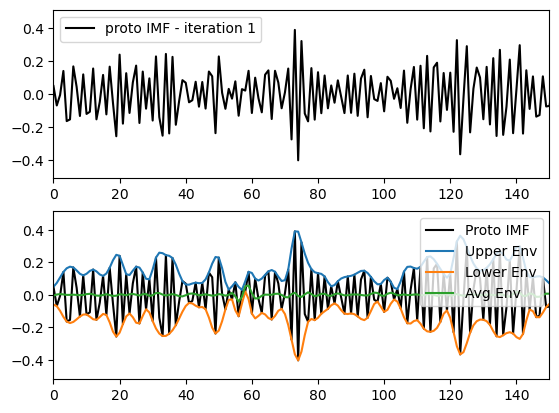

In [5]:
# Subtract slow dynamics from previous cell
proto_imf = proto_imf - avg_env

# Compute upper and lower envelopes
upper_env = emd.sift.interp_envelope(proto_imf, mode='upper')
lower_env = emd.sift.interp_envelope(proto_imf, mode='lower')

# Compute average envelope
avg_env = (upper_env+lower_env) / 2

plt.figure()
plt.subplot(211)
plt.plot(proto_imf, 'k')
plt.xlim(0, 150)
plt.legend(['proto IMF - iteration 1'])

plt.subplot(212)
plt.plot(proto_imf, 'k')
plt.plot(upper_env)
plt.plot(lower_env)
plt.plot(avg_env)
plt.xlim(0, 150)
plt.legend(['Proto IMF', 'Upper Env', 'Lower Env', 'Avg Env'])

In [6]:
def my_get_next_imf(x, zoom=None, sd_thresh=0.1):

    proto_imf = x.copy()  # Take a copy of the input so we don't overwrite anything
    continue_sift = True  # Define a flag indicating whether we should continue sifting
    niters = 0            # An iteration counter

    if zoom is None:
        zoom = (0, x.shape[0])

    # Main loop - we don't know how many iterations we'll need so we use a ``while`` loop
    while continue_sift:
        niters += 1  # Increment the counter

        # Compute upper and lower envelopes
        upper_env = emd.sift.interp_envelope(proto_imf, mode='upper')
        lower_env = emd.sift.interp_envelope(proto_imf, mode='lower')

        # Compute average envelope
        avg_env = (upper_env+lower_env) / 2

        # Add a summary subplot
        plt.subplot(5, 1, niters)
        plt.plot(proto_imf[zoom[0]:zoom[1]], 'k')
        plt.plot(upper_env[zoom[0]:zoom[1]])
        plt.plot(lower_env[zoom[0]:zoom[1]])
        plt.plot(avg_env[zoom[0]:zoom[1]])

        # Should we stop sifting?
        stop, val = emd.sift.sd_stop(proto_imf-avg_env, proto_imf, sd=sd_thresh)

        # Remove envelope from proto IMF
        proto_imf = proto_imf - avg_env

        # and finally, stop if we're stopping
        if stop:
            continue_sift = False

    # Return extracted IMF
    return proto_imf

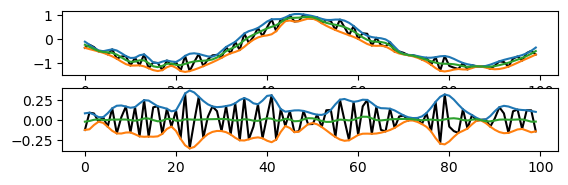

In [7]:
imf1 = my_get_next_imf(x, zoom=(100, 200))

([], [])

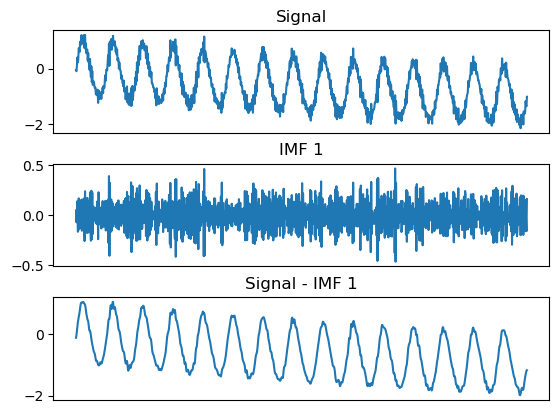

In [8]:
plt.figure()
plt.subplots_adjust(hspace=0.3)

plt.subplot(311)
plt.plot(x)
plt.title('Signal')
plt.xticks([])

plt.subplot(312)
plt.plot(imf1)
plt.title('IMF 1')
plt.xticks([])

plt.subplot(313)
plt.plot(x - imf1)
plt.title('Signal - IMF 1')
plt.xticks([])

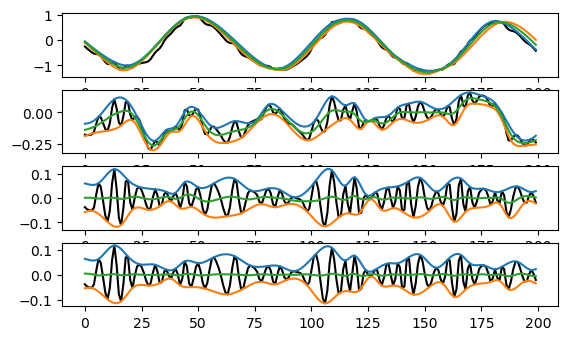

In [9]:
imf2 = my_get_next_imf(x - imf1, zoom=(100, 300))

([], [])

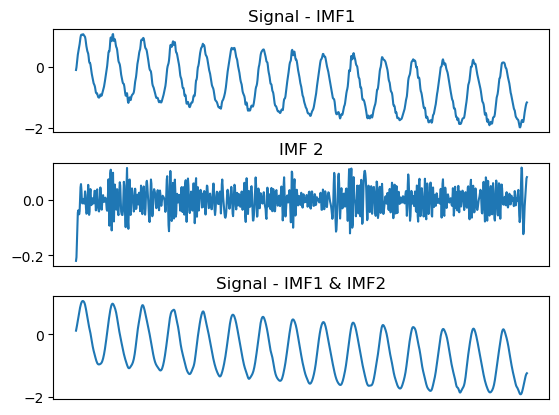

In [10]:
plt.figure()
plt.subplots_adjust(hspace=0.3)

plt.subplot(311)
plt.plot(x - imf1)
plt.title('Signal - IMF1')
plt.xticks([])

plt.subplot(312)
plt.plot(imf2)
plt.title('IMF 2')
plt.xticks([])

plt.subplot(313)
plt.plot(x - imf1 - imf2)
plt.title('Signal - IMF1 & IMF2')
plt.xticks([])

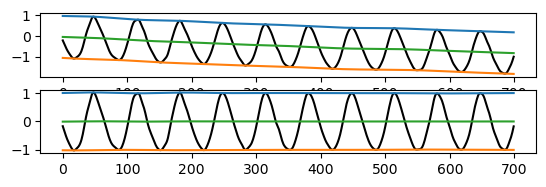

In [11]:
imf3 = my_get_next_imf(x - imf1 - imf2, zoom=(100, 800))

([], [])

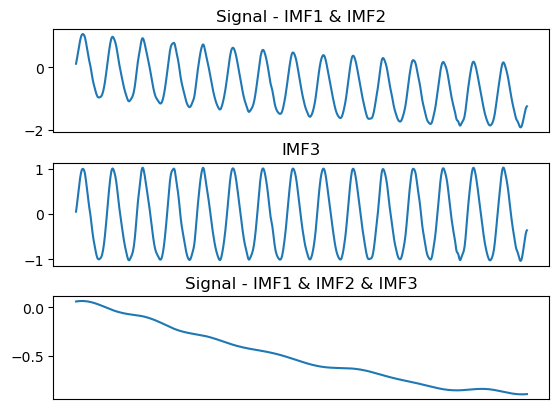

In [12]:
plt.figure()
plt.subplots_adjust(hspace=0.3)

plt.subplot(311)
plt.plot(x - imf1 - imf2)
plt.title('Signal - IMF1 & IMF2')
plt.xticks([])

plt.subplot(312)
plt.plot(imf3)
plt.title('IMF3')
plt.xticks([])

plt.subplot(313)
plt.plot(x - imf1 - imf2 - imf3)
plt.title('Signal - IMF1 & IMF2 & IMF3')
plt.xticks([])

<Axes: xlabel='Time (samples)'>

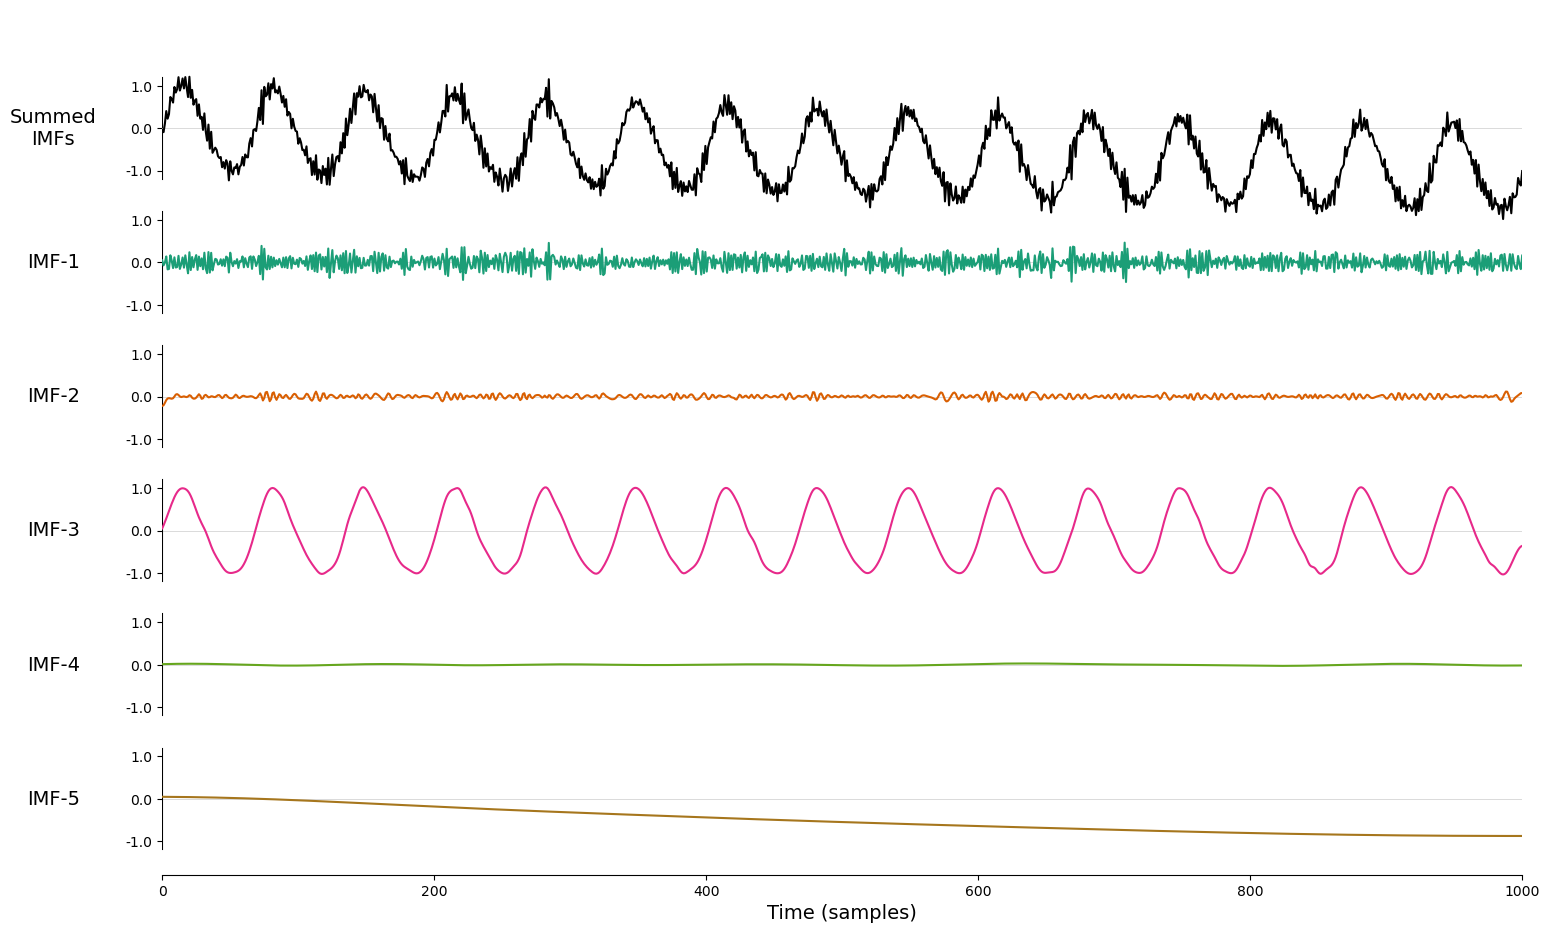

In [13]:
imf = emd.sift.sift(x, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf)


                                              0.0/6.6 MB ? eta -:--:--
                                              0.1/6.6 MB 2.4 MB/s eta 0:00:03
     ---                                      0.5/6.6 MB 5.4 MB/s eta 0:00:02
     ------                                   1.0/6.6 MB 7.0 MB/s eta 0:00:01
     ----------                               1.7/6.6 MB 9.0 MB/s eta 0:00:01
     ---------------                          2.6/6.6 MB 11.2 MB/s eta 0:00:01
     ----------------------                   3.6/6.6 MB 12.9 MB/s eta 0:00:01
     ------------------------------           5.1/6.6 MB 15.4 MB/s eta 0:00:01
     -------------------------------------    6.1/6.6 MB 16.2 MB/s eta 0:00:01
     ---------------------------------------- 6.6/6.6 MB 16.2 MB/s eta 0:00:00
                                              0.0/347.7 kB ? eta -:--:--
     ---------------------------------------- 347.7/347.7 kB ? eta 0:00:00
  Using cached future-0.18.3.tar.gz (840 kB)
  Preparing metadata (setup.